# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


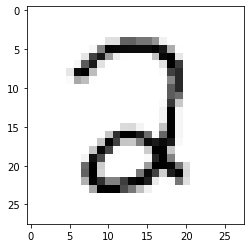

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2392
Training Accuracy: 0.7071, Testing Accuracy: 0.6820



Epoch 10, Loss 0.1126
Training Accuracy: 0.9051, Testing Accuracy: 0.9128



Epoch 20, Loss 0.0652
Training Accuracy: 0.9338, Testing Accuracy: 0.9435



Epoch 30, Loss 0.0491
Training Accuracy: 0.9459, Testing Accuracy: 0.9541



Epoch 40, Loss 0.0413
Training Accuracy: 0.9534, Testing Accuracy: 0.9617



Epoch 50, Loss 0.0368
Training Accuracy: 0.9574, Testing Accuracy: 0.9662



Epoch 60, Loss 0.0338
Training Accuracy: 0.9594, Testing Accuracy: 0.9672



Epoch 70, Loss 0.0316
Training Accuracy: 0.9616, Testing Accuracy: 0.9677



Epoch 80, Loss 0.0299
Training Accuracy: 0.9636, Testing Accuracy: 0.9677



Epoch 90, Loss 0.0284
Training Accuracy: 0.9651, Testing Accuracy: 0.9698



Epoch 100, Loss 0.0273
Training Accuracy: 0.9666, Testing Accuracy: 0.9708



Epoch 110, Loss 0.0262
Training Accuracy: 0.9684, Testing Accuracy: 0.9718



Epoch 120, Loss 0.0253
Training Accuracy: 0.9700, Testing Accuracy: 0.9728



Epoch 130, Loss 0.0245
Training Accuracy: 0.9708, Testing Accuracy: 0.9733



Epoch 140, Loss 0.0238
Training Accuracy: 0.9716, Testing Accuracy: 0.9743



Epoch 150, Loss 0.0232
Training Accuracy: 0.9730, Testing Accuracy: 0.9738



Epoch 160, Loss 0.0226
Training Accuracy: 0.9740, Testing Accuracy: 0.9743



Epoch 170, Loss 0.022
Training Accuracy: 0.9745, Testing Accuracy: 0.9758



Epoch 180, Loss 0.0215
Training Accuracy: 0.9755, Testing Accuracy: 0.9758



Epoch 190, Loss 0.021
Training Accuracy: 0.9760, Testing Accuracy: 0.9758



Epoch 200, Loss 0.0205
Training Accuracy: 0.9766, Testing Accuracy: 0.9753



Epoch 210, Loss 0.0201
Training Accuracy: 0.9770, Testing Accuracy: 0.9748



Epoch 220, Loss 0.0197
Training Accuracy: 0.9775, Testing Accuracy: 0.9753



Epoch 230, Loss 0.0193
Training Accuracy: 0.9781, Testing Accuracy: 0.9763



Epoch 240, Loss 0.0189
Training Accuracy: 0.9787, Testing Accuracy: 0.9763



0.005374899158140363

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2409
Training Accuracy: 0.6764, Testing Accuracy: 0.6941



Epoch 10, Loss 0.1026
Training Accuracy: 0.9099, Testing Accuracy: 0.9279



Epoch 20, Loss 0.0791
Training Accuracy: 0.9275, Testing Accuracy: 0.9430



Epoch 30, Loss 0.0682
Training Accuracy: 0.9364, Testing Accuracy: 0.9491



Epoch 40, Loss 0.0617
Training Accuracy: 0.9417, Testing Accuracy: 0.9546



Epoch 50, Loss 0.0572
Training Accuracy: 0.9458, Testing Accuracy: 0.9567



Epoch 60, Loss 0.0539
Training Accuracy: 0.9481, Testing Accuracy: 0.9582



Epoch 70, Loss 0.0513
Training Accuracy: 0.9494, Testing Accuracy: 0.9597



Epoch 80, Loss 0.0492
Training Accuracy: 0.9510, Testing Accuracy: 0.9607



Epoch 90, Loss 0.0475
Training Accuracy: 0.9521, Testing Accuracy: 0.9607



Epoch 100, Loss 0.0461
Training Accuracy: 0.9534, Testing Accuracy: 0.9627



Epoch 110, Loss 0.0449
Training Accuracy: 0.9543, Testing Accuracy: 0.9652



Epoch 120, Loss 0.0438
Training Accuracy: 0.9555, Testing Accuracy: 0.9657



Epoch 130, Loss 0.0429
Training Accuracy: 0.9563, Testing Accuracy: 0.9657



Epoch 140, Loss 0.042
Training Accuracy: 0.9570, Testing Accuracy: 0.9662



Epoch 150, Loss 0.0413
Training Accuracy: 0.9576, Testing Accuracy: 0.9662



Epoch 160, Loss 0.0406
Training Accuracy: 0.9582, Testing Accuracy: 0.9667



Epoch 170, Loss 0.04
Training Accuracy: 0.9584, Testing Accuracy: 0.9682



Epoch 180, Loss 0.0394
Training Accuracy: 0.9588, Testing Accuracy: 0.9682



Epoch 190, Loss 0.0389
Training Accuracy: 0.9590, Testing Accuracy: 0.9677



Epoch 200, Loss 0.0384
Training Accuracy: 0.9593, Testing Accuracy: 0.9688



Epoch 210, Loss 0.038
Training Accuracy: 0.9593, Testing Accuracy: 0.9693



Epoch 220, Loss 0.0376
Training Accuracy: 0.9598, Testing Accuracy: 0.9693



Epoch 230, Loss 0.0372
Training Accuracy: 0.9602, Testing Accuracy: 0.9693



Epoch 240, Loss 0.0368
Training Accuracy: 0.9607, Testing Accuracy: 0.9693



0.030054355047304516

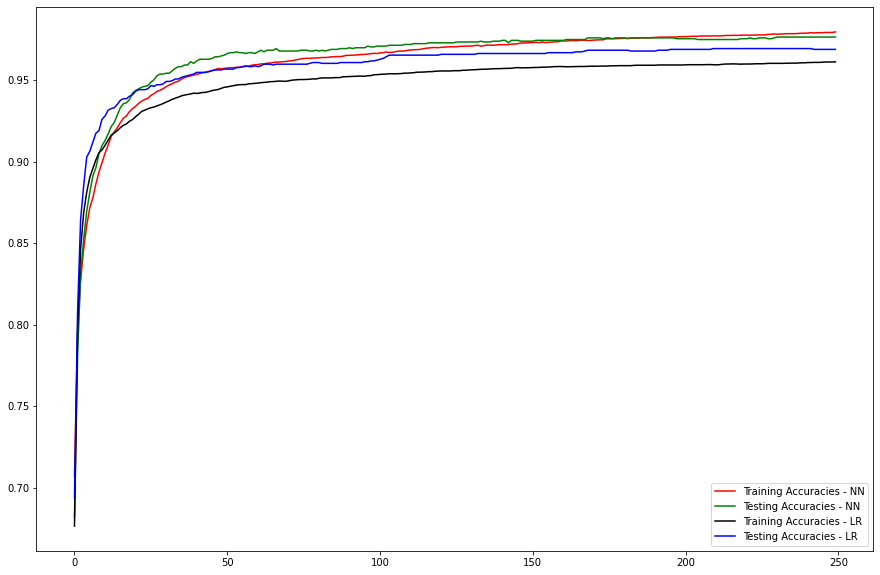

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

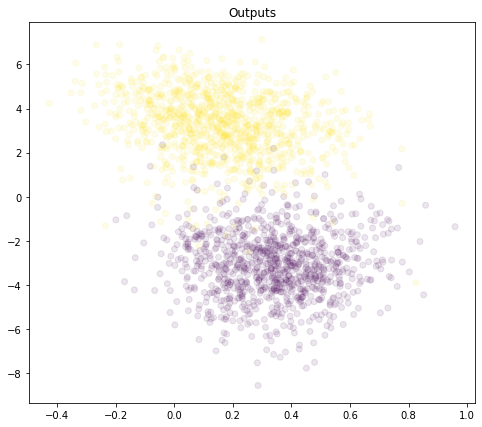

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

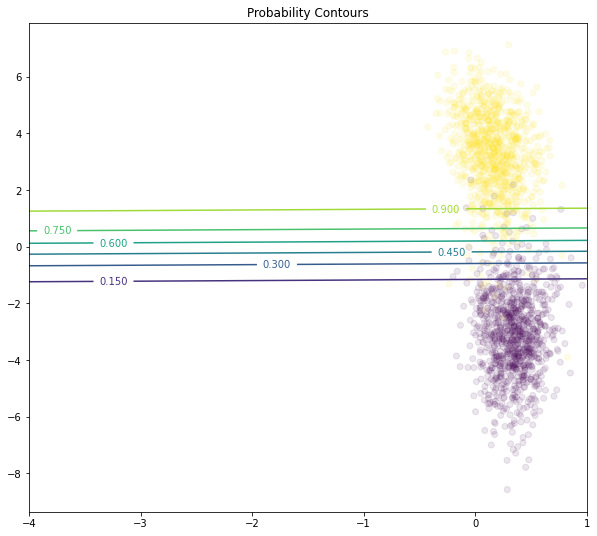

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );